In [164]:
from pulp import *
import timeit

In [165]:
#Initialize the model
model = pulp.LpProblem("Maximize-Profit", LpMaximize)

In [166]:
# Selling Prices per box
Selling_Prices = {
    'GT50': 6, 'GT100': 10, 'BT50': 7, 'BT100': 12,
    'WT50': 9, 'WT100': 16, 'RT50': 8, 'RT100': 14
}

# Buying Prices per 100g
Buying_Prices = {'GT': 3.5, 'BT': 4.5, 'WT': 5.5, 'RT': 5.0}

#Types of Tea 
Teas = ['GT', 'BT', 'WT', 'RT']
#Packaging sizes
Sizes = [50, 100]
#Countries that we will be shipping the Tea to
Countries = ['Portugal', 'Spain', 'France', 'Italy', 'Germany', 'Poland']

# Distribution costs per box
Distribution_Costs = {
    'Portugal': 0.5, 'Spain': 0.4, 'France': 0.6,
    'Italy': 0.7, 'Germany': 0.8, 'Poland': 1.0
}

In [167]:
Demand_Forecast = {
    ('Portugal', 'GT50'): 100, ('Portugal', 'GT100'): 80,
    ('Portugal', 'BT50'): 90,  ('Portugal', 'BT100'): 70,
    ('Portugal', 'WT50'): 50,  ('Portugal', 'WT100'): 40,
    ('Portugal', 'RT50'): 60,  ('Portugal', 'RT100'): 50,
    ('Spain', 'GT50'): 150,    ('Spain', 'GT100'): 120,
    ('Spain', 'BT50'): 130,    ('Spain', 'BT100'): 110,
    ('Spain', 'WT50'): 80,     ('Spain', 'WT100'): 60,
    ('Spain', 'RT50'): 100,    ('Spain', 'RT100'): 90,
    ('France', 'GT50'): 200,   ('France', 'GT100'): 170,
    ('France', 'BT50'): 180,   ('France', 'BT100'): 160,
    ('France', 'WT50'): 100,   ('France', 'WT100'): 90,
    ('France', 'RT50'): 120,   ('France', 'RT100'): 110,
    ('Italy', 'GT50'): 130,    ('Italy', 'GT100'): 110,
    ('Italy', 'BT50'): 120,    ('Italy', 'BT100'): 100,
    ('Italy', 'WT50'): 70,     ('Italy', 'WT100'): 60,
    ('Italy', 'RT50'): 90,     ('Italy', 'RT100'): 80,
    ('Germany', 'GT50'): 180,  ('Germany', 'GT100'): 160,
    ('Germany', 'BT50'): 170,  ('Germany', 'BT100'): 150,
    ('Germany', 'WT50'): 90,   ('Germany', 'WT100'): 80,
    ('Germany', 'RT50'): 110,  ('Germany', 'RT100'): 100,
    ('Poland', 'GT50'): 120,   ('Poland', 'GT100'): 100,
    ('Poland', 'BT50'): 110,   ('Poland', 'BT100'): 90,
    ('Poland', 'WT50'): 60,    ('Poland', 'WT100'): 50,
    ('Poland', 'RT50'): 80,    ('Poland', 'RT100'): 70
}

In [168]:
#fixed costs
marketing_cost = 400000
fixed_annual_cost = 4000000
total_annual_cost = marketing_cost + fixed_annual_cost
production_cost_per_box = 1

#constants
max_production = 2000000

#Raw Tea Availability
Raw_Tea_Availability = {
    'GT': 25000000, 'BT': 30000000,
    'WT': 15000000, 'RT': 20000000
}

In [169]:
# Define the decision variables, but we use the LpVariable.dicts() method to create a dictionary of decision variables as opposed to creating each one individually. It is due to the fact that we have 48 of them as 2 sizes * 4 types * 6 countries.
variables = LpVariable.dicts("Tea_Boxes", [(t, s, c) for t in Teas for s in Sizes for c in Countries], lowBound=0, cat='Integer')

In [ ]:
# Find Revenue that will be used in objective function later as in lab 1 4.5 * Beer + 5 * Wine but we don't have to write it all down as we have a dictionary of selling prices.
Revenue = lpSum([Selling_Prices[f"{t}{s}"] * variables[(t, s, c)] for t in Teas for s in Sizes for c in Countries])

#costs ber pox for each type of tea and size, similarly as above we have a dictionary of buying prices and distribution costs for each country. 48 different costs.
Variable_Costs = {}
for t in Teas: #iterate through the types of tea
    for s in Sizes: #iterate through the sizes
        size_factor = s / 100  
        buying_cost = Buying_Prices[t] * size_factor 
        for c in Countries:
            total_var_cost = buying_cost + production_cost_per_box + Distribution_Costs[c]
            Variable_Costs[(t, s, c)] = total_var_cost

# Find the total variable cost (simply multiply the decision variables by the variable costs and sum them up)

Total_Variable_Cost = pulp.lpSum(
    Variable_Costs[(t, s, c)] * variables[(t, s, c)]
    for t in Teas for s in Sizes for c in Countries
)


Model with all constraints such as max amount of boxes , raw tea availability, minimum production constraints and minimum demand for each type of tea and size

In [171]:
model += Revenue - Total_Variable_Cost - total_annual_cost

#production constraints however, it doesn't matter as we have 90mln gram of raw tea and if we all pack them to 50g boxes it will only be 1.8mln boxes
model += pulp.lpSum(
    variables[(t, s, c)] for t in Teas for s in Sizes for c in Countries
) <= 2000000, "Production_Capacity"

#Raw Tea Availability constraints
for t in Teas:
    model += pulp.lpSum(
        variables[(t, s, c)] * s  
        for s in Sizes for c in Countries
    ) <= Raw_Tea_Availability[t], f"Raw_Tea_{t}"

#minimum production constraints for each type of tea
total_boxes = pulp.lpSum(
    variables[(t, s, c)] for t in Teas for s in Sizes for c in Countries
)

for t in Teas:
    model += pulp.lpSum(
        variables[(t, s, c)] for s in Sizes for c in Countries
    ) >= 0.1 * total_boxes, "Minimum_Production_" + t

# Demand constraints
for t in Teas:
    for s in Sizes:
        for c in Countries:
            demand = Demand_Forecast.get((c, f"{t}{s}"), 0)
            model += variables[(t, s, c)] >= demand, f"MinDemand_{t}_{s}_{c}"

# Solve the model
model.solve()

1

In [172]:
print("Status:", LpStatus[model.status])

for v in model.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

print("Total Profit (including fixed costs) = $", pulp.value(model.objective))


Status: Optimal
Tea_Boxes_('BT',_100,_'France') = 160.0
Tea_Boxes_('BT',_100,_'Germany') = 150.0
Tea_Boxes_('BT',_100,_'Italy') = 100.0
Tea_Boxes_('BT',_100,_'Poland') = 90.0
Tea_Boxes_('BT',_100,_'Portugal') = 70.0
Tea_Boxes_('BT',_100,_'Spain') = 110.0
Tea_Boxes_('BT',_50,_'France') = 180.0
Tea_Boxes_('BT',_50,_'Germany') = 170.0
Tea_Boxes_('BT',_50,_'Italy') = 120.0
Tea_Boxes_('BT',_50,_'Poland') = 110.0
Tea_Boxes_('BT',_50,_'Portugal') = 90.0
Tea_Boxes_('BT',_50,_'Spain') = 597970.0
Tea_Boxes_('GT',_100,_'France') = 170.0
Tea_Boxes_('GT',_100,_'Germany') = 160.0
Tea_Boxes_('GT',_100,_'Italy') = 110.0
Tea_Boxes_('GT',_100,_'Poland') = 100.0
Tea_Boxes_('GT',_100,_'Portugal') = 80.0
Tea_Boxes_('GT',_100,_'Spain') = 120.0
Tea_Boxes_('GT',_50,_'France') = 200.0
Tea_Boxes_('GT',_50,_'Germany') = 180.0
Tea_Boxes_('GT',_50,_'Italy') = 130.0
Tea_Boxes_('GT',_50,_'Poland') = 120.0
Tea_Boxes_('GT',_50,_'Portugal') = 100.0
Tea_Boxes_('GT',_50,_'Spain') = 497790.0
Tea_Boxes_('RT',_100,_'France'

All of the below is out of picture but wanted to show that after reading the task my first idea was that it's all going to go to Spain after fulfilling the demand as it has the smallest transportation cost

In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import LpStatus


In [ ]:
import re

data = []

for v in model.variables():
    if v.varValue > 0:
        var_name = v.name
        var_value = v.varValue

        match = re.match(r"Tea_Boxes_\('(\w+)',_(\d+),_'(\w+)'\)", var_name)
        if match:
            tea = match.group(1)
            size = match.group(2)
            country = match.group(3)
            data.append({'Tea': tea, 'Size': size, 'Country': country, 'Value': var_value})
        else:
            print(f"Unexpected variable name format: {var_name}")

df = pd.DataFrame(data)


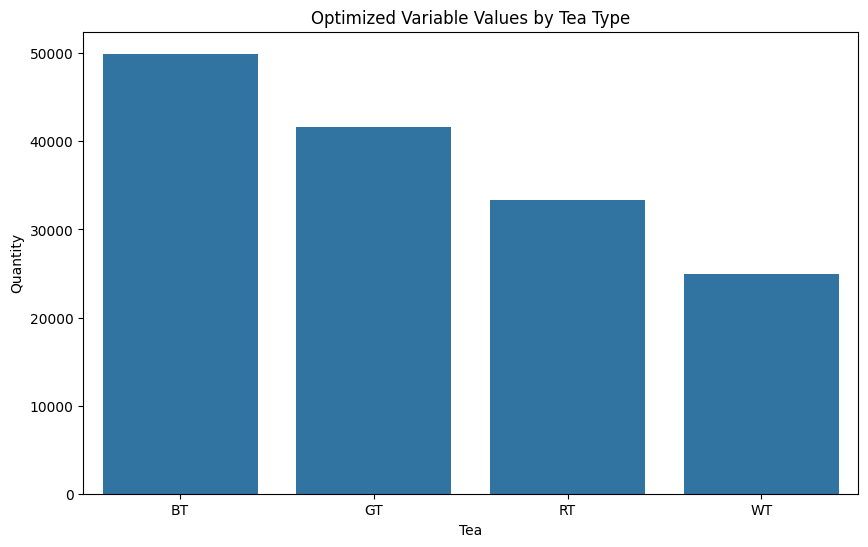

In [178]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Tea', y='Value', data=df, errorbar=None)
plt.title('Optimized Variable Values by Tea Type')
plt.ylabel('Quantity')
plt.show()


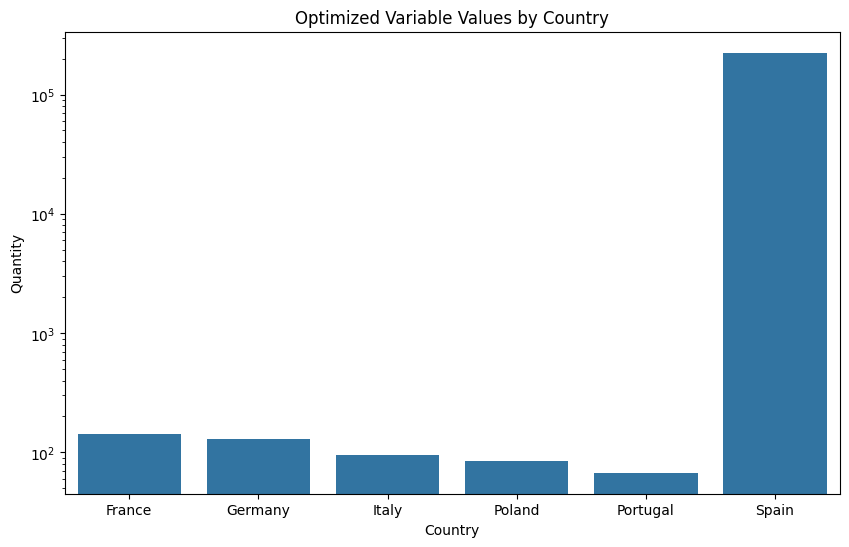

In [182]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Country', y='Value', data=df, errorbar=None)
plt.title('Optimized Variable Values by Country')
plt.ylabel('Quantity')
plt.yscale('log')
plt.show()


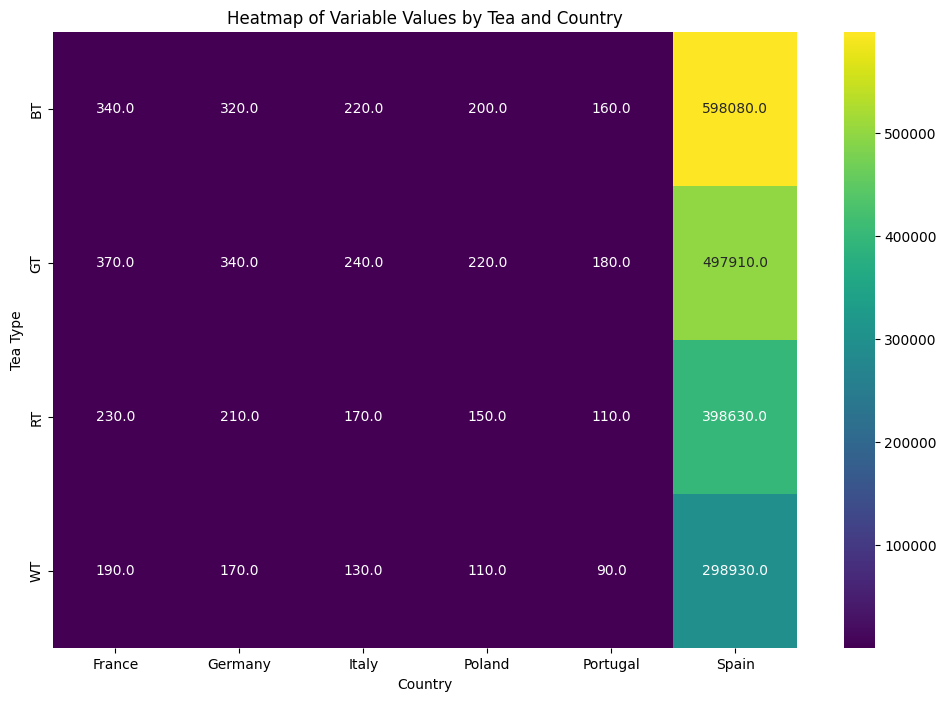

In [ ]:
pivot_table = df.pivot_table(values='Value', index='Tea', columns='Country', aggfunc='sum', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='viridis')
plt.title('Heatmap of Variable Values by Tea and Country')
plt.ylabel('Tea Type')
plt.xlabel('Country')
plt.show()

#this graph proves statement above that we fulfill the demand and the rest goes to one country

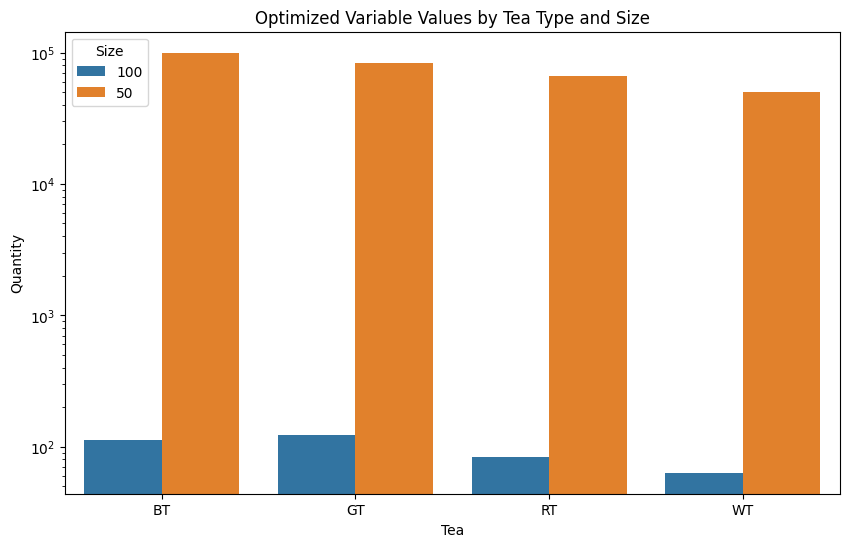

In [183]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Tea', y='Value', hue='Size', data=df, errorbar=None)
plt.title('Optimized Variable Values by Tea Type and Size')
plt.ylabel('Quantity')
plt.legend(title='Size')
plt.yscale('log')
plt.show()
